In [1]:
!pip install -q xlrd
!pip install -q openpyxl
!pip install -q langdetect

In [2]:
import numpy as np
import pandas as pd
import re, string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from langdetect import detect_langs
import fastprogress
from collections import Counter
import matplotlib.cm as cm

In [3]:
df = pd.read_excel('../input/learning/input_data-1.xlsx')
df['Description'] = df['Description'].str.replace(r'(_x000D_\n)+', ' ', regex=True)
df['combined desc'] = df['Short description'] + df['Description']

### missing values
in percentage

In [4]:
df.isna().mean()

Short description    0.000941
Description          0.000118
Caller               0.000000
Assignment group     0.000000
combined desc        0.001059
dtype: float64

counts

In [5]:
df.isna().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
combined desc        9
dtype: int64

In [6]:
df = df.dropna().reset_index(drop=True)
df.shape

(8491, 5)

## label distribution

In [7]:
df['Assignment group'].nunique()

74

<AxesSubplot:ylabel='Assignment group'>

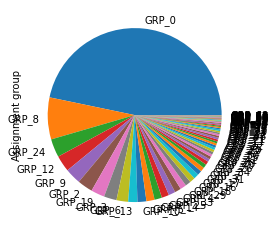

In [8]:
df['Assignment group'].value_counts().plot.pie()

#### 7 classes have only one example which makes it difficult to have a proper split between train and validation

In [9]:
label_dist = df['Assignment group'].value_counts().reset_index()
label_dist[label_dist['Assignment group'] == 1]

,index,Assignment group
68,GRP_35,1
69,GRP_70,1
70,GRP_67,1
71,GRP_73,1
72,GRP_64,1
73,GRP_61,1


## rare groups less tha 50 samples per class

<AxesSubplot:xlabel='index'>

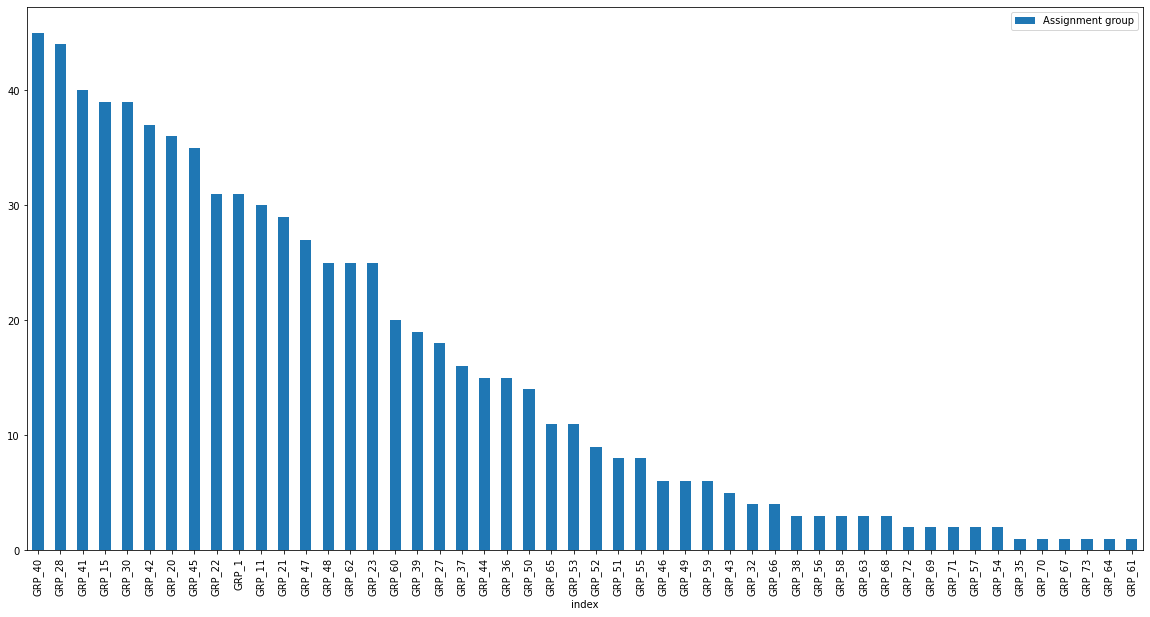

In [10]:
label_dist[label_dist['Assignment group'] <= 50].set_index('index').plot.bar(figsize=(20, 10))

## dropping classes with frequency one in the dataset

In [11]:
drop_classes = label_dist[label_dist['Assignment group'] == 1]['index'].values
df = df[~df['Assignment group'].isin(drop_classes)].reset_index(drop=True)

59 classes have example count less than 100

In [12]:
label_dist[label_dist['Assignment group'] <= 100].shape

(59, 2)

In [13]:
for k, item in df.iterrows():
    df.iloc[k, 1] = item['combined desc'].replace('.'.join(item['Caller'].split()), 'ename')

In [14]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub(r'\d+', ' ', x)

In [15]:
df['combined desc'] = df['combined desc'].str.lower()
# df['Description'] = df['Description'].apply(clean_text)
df['combined desc'] = df['combined desc'].apply(clean_numbers)
df['combined desc'] = df['combined desc'].str.strip()
# df['Description'] = df['Description'].replace({ r'\A\s+|\s+\Z': '', '\n' : ' '}, regex=True)
# df['Description'] = df['Description'].replace(r'_|-|-|–|―|−|―|—|─|¯', ' ', regex=True)
# df['Description'] = df['Description'].replace(r'\b[b-x]\b', ' ', regex=True)
# df['Description'] = df['Description'].replace(r'\\s+', r' ', regex=True)

In [16]:
lang_acc = []
for k, item in fastprogress.progress_bar(df.iterrows(), total=df.shape[0]):
    lang_acc.append(detect_langs(item['combined desc']))

In [17]:
Counter(list(map(lambda x: x.lang, sum(lang_acc, []))))

Counter({'en': 7443,
         'it': 330,
         'no': 200,
         'ca': 148,
         'et': 33,
         'af': 451,
         'fr': 278,
         'es': 126,
         'da': 295,
         'sv': 164,
         'nl': 206,
         'sl': 357,
         'cy': 59,
         'tl': 36,
         'sq': 23,
         'id': 7,
         'pl': 75,
         'de': 445,
         'so': 25,
         'pt': 66,
         'tr': 12,
         'cs': 7,
         'sk': 10,
         'ro': 37,
         'hr': 17,
         'fi': 20,
         'lv': 3,
         'lt': 5,
         'hu': 3,
         'sw': 2})

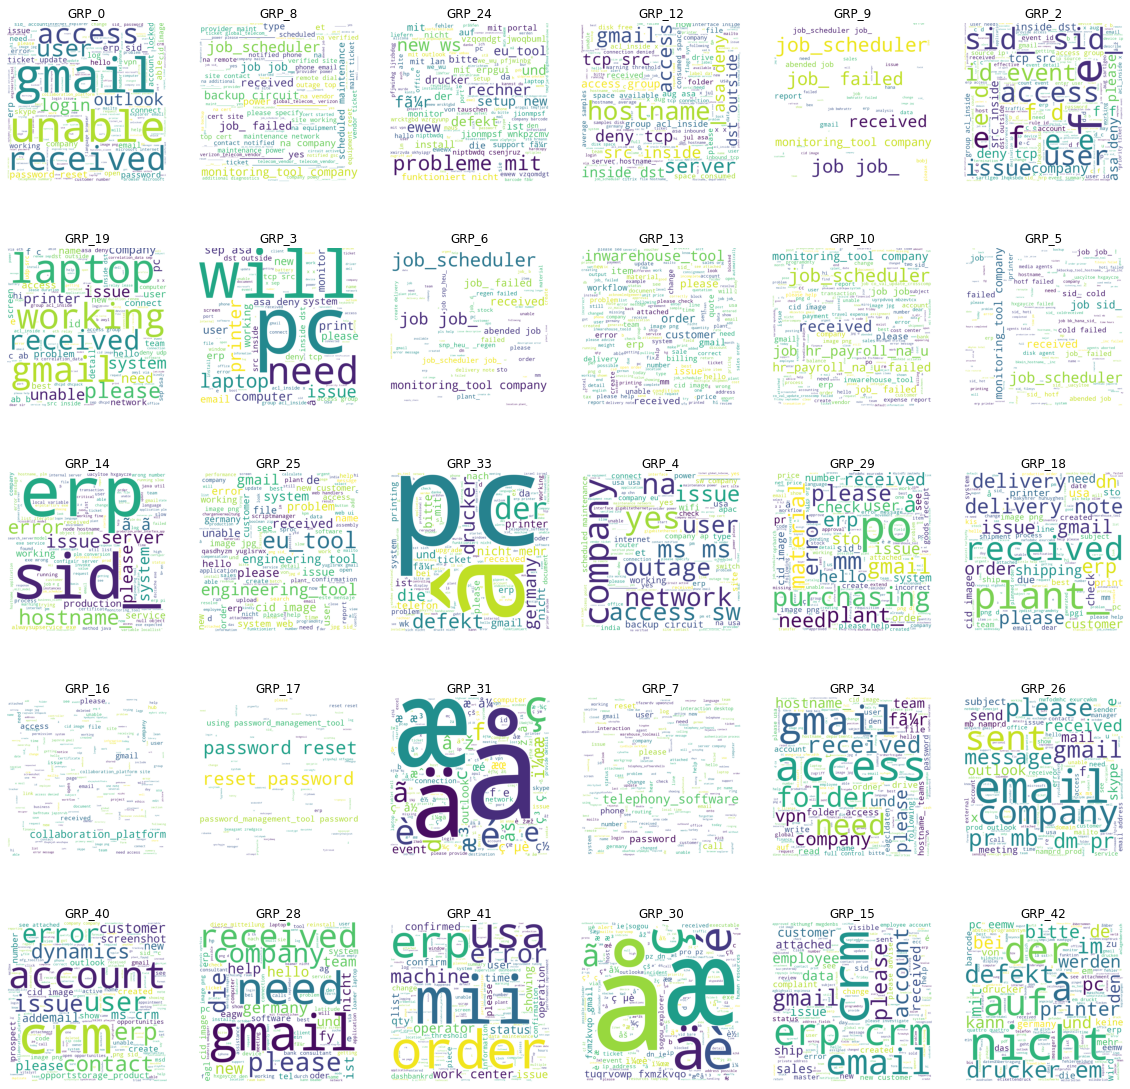

In [18]:
fig, axes = plt.subplots(5, 6, figsize=(20, 20))
fig.subplots_adjust(wspace=None, hspace=None)
stopwords = set(STOPWORDS)

for k, (ax, label) in enumerate(zip(axes.ravel(), df['Assignment group'].value_counts().index)):
    comb_sent = ' '.join(df.loc[df['Assignment group']==label, 'combined desc'])
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comb_sent)
    ax.set_title(label)
    ax.imshow(wordcloud)
    ax.axis('off')

### tokenization

In [19]:
!python -m spacy download xx_ent_wiki_sm

     |████████████████████████████████| 3.7 MB 4.2 MB/s 
  Created wheel for xx-ent-wiki-sm: filename=xx_ent_wiki_sm-2.3.0-py3-none-any.whl size=3741309 sha256=634da62ac5c46afd90cba03c5fa07b044b97ae85b10dd110ebc718a8c2ee6caf
  Stored in directory: /root/.cache/pip/wheels/6d/3a/e2/6f3c30d9b864273b5c88e6cf82e83bdafff5296cd949915598
Successfully built xx-ent-wiki-sm
✔ Download and installation successful
You can now load the model via spacy.load('xx_ent_wiki_sm')


In [20]:
from spacy.tokenizer import Tokenizer
import xx_ent_wiki_sm
nlp = xx_ent_wiki_sm.load()

In [21]:
tokenizer = Tokenizer(nlp.vocab)

In [22]:
df['combined desc'] = df['combined desc'].map(tokenizer).map(lambda x: ' '.join(x.text.split()))

In [23]:
df

,Short description,Description,Caller,Assignment group,combined desc
0,login issue,login issue-verified user details.(employee# &...,spxjnwir pjlcoqds,GRP_0,login issue-verified user details.(employee# &...
1,outlook,outlook received from: ename@gmail.com hello t...,hmjdrvpb komuaywn,GRP_0,outlook received from: hmjdrvpb.komuaywn@gmail...
2,cant log in to vpn,cant log in to vpn received from: ename@gmail....,eylqgodm ybqkwiam,GRP_0,cant log in to vpn received from: eylqgodm.ybq...
3,unable to access hr_tool page,unable to access hr_tool pageunable to access ...,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool pageunable to access ...
4,skype error,skype error skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error
...,...,...,...,...,...
8480,emails not coming in from zz mail,emails not coming in from zz mail received fro...,avglmrts vhqmtiua,GRP_29,emails not coming in from zz mail received fro...
8481,telephony_software issue,telephony_software issuetelephony_software issue,rbozivdq gmlhrtvp,GRP_0,telephony_software issuetelephony_software issue
8482,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0,vip : windows password reset for tifpdchb pedx...
8483,machine nÃ£o estÃ¡ funcionando,machine nÃ£o estÃ¡ funcionandoi am unable to a...,ufawcgob aowhxjky,GRP_62,machine nã£o estã¡ funcionandoi am unable to a...


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [25]:
vocab = set(' '.join(df['combined desc']).split())

In [26]:
# targ_enc = LabelEncoder()
# targ = targ_enc.fit_transform(df['Assignment group'])

In [27]:
x_train, x_val, y_train, y_val = train_test_split(df['combined desc'], df['Assignment group'], random_state=2021, shuffle=True)

In [28]:
lr_pipe = make_pipeline(
                    TfidfVectorizer(decode_error='replace', max_features=5000),
                    LogisticRegression(solver='liblinear'))

In [29]:
data = TfidfVectorizer(decode_error='replace').fit_transform(df['combined desc'])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters


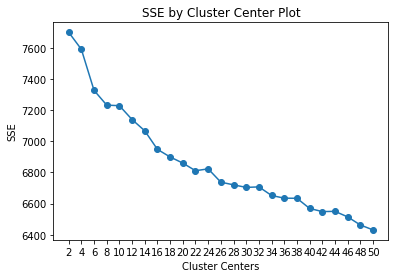

In [30]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(data, 50)

In [31]:
clusters = MiniBatchKMeans(n_clusters=40, init_size=1024, batch_size=2048, random_state=20).fit_predict(data)

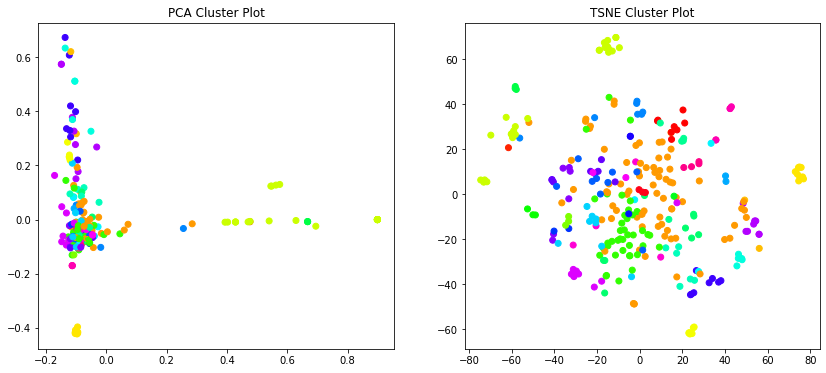

In [32]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(data, clusters)

In [33]:
# TfidfVectorizer(decode_error='replace').fit_transform(df['Short description'])

In [34]:
lr_pipe = make_pipeline(
                    TfidfVectorizer(decode_error='replace', max_features=5000),
                    LogisticRegression(solver='liblinear'))

In [35]:
lr_pipe.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(decode_error='replace', max_features=5000)),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [36]:
lr_pipe.score(x_val, y_val)

0.6427898209236569

In [37]:
lr_pipe = make_pipeline(CountVectorizer(vocabulary=vocab),
                       TfidfTransformer(), LogisticRegression(solver='liblinear'))

In [38]:
lr_pipe.fit(x_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(vocabulary={'!', '!!', '!!!', '!!!!', '!!!!!',
                                             '!!!!!!!!!!!!!!!!!!!!!!',
                                             '!!!drucker', '!?', '!production',
                                             '"', '"\'', '",', '".',
                                             '"/nfsbackup', '"?',
                                             '"\\\\hostname_', '"a', '"access',
                                             '"acl_inside"', '"activity',
                                             '"actual.jpg"', '"add',
                                             '"additional', '"adelhmk"',
                                             '"adobe', '"ae', '"an',
                                             '"analysis', '"anniversary',
                                             '"ansi', ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('logisticregression', 

In [39]:
lr_pipe.score(x_val, y_val)

0.6295947219604147

In [40]:
# plt.matshow(confusion_matrix(lr_pipe.predict(x_val), y_val))

In [41]:
# lr_pipe.score(x_val, y_val)⁄

In [42]:
# y_val.nunique()

In [43]:
# df['Assignment group']

In [44]:
# plot_confusion_matrix(lr_pipe, x_val, y_val)